In [1]:
import pandas as pd
import numpy as np
import joblib
import requests
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

In [20]:
df = pd.read_csv("gym_members_exercise_tracking.csv")
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [4]:
df.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'],
      dtype='object')

In [5]:
columns_needed = [
    'Age',
    'Gender',
    'Height (m)',
    'Weight (kg)',
    'Session_Duration (hours)',
    'Workout_Type'
]

# Subset and copy data
df_selected = df[columns_needed].copy()

# Add random Workout Days column
np.random.seed(42)
df_selected["Workout Days"] = np.random.choice([2, 3, 4, 5, 6], size=len(df_selected))

# Encode categorical variables
label_encoders = {}
for col in ['Gender', 'Workout_Type']: 
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    label_encoders[col] = le

# Split features and target
X = df_selected.drop(columns=['Workout_Type'])
y = df_selected['Workout_Type']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'criterion': ['gini']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_scaled, y)

rf_model = grid_search.best_estimator_

y_pred = rf_model.predict(X_scaled)
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='macro')

print("✅ Accuracy:", accuracy)
print("✅ F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y, y_pred))


joblib.dump(rf_model, "custom_rf_workout_model.pkl")
joblib.dump(scaler, "custom_rf_scaler.pkl")
joblib.dump(label_encoders, "custom_rf_label_encoders.pkl")

✅ Accuracy: 0.9886947584789312
✅ F1 Score: 0.9884720585924731

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       255
           1       1.00      0.97      0.98       221
           2       0.99      1.00      0.99       258
           3       0.99      0.99      0.99       239

    accuracy                           0.99       973
   macro avg       0.99      0.99      0.99       973
weighted avg       0.99      0.99      0.99       973



['custom_rf_label_encoders.pkl']

In [ ]:
def recommend_workout(user_input):
    feature_order = ['Age', 'Gender', 'Height (m)', 'Weight (kg)', 'Session_Duration (hours)', 'Workout Days']
    input_vector = []
    for feature in feature_order:
        val = user_input[feature]
        if feature in label_encoders:
            val = label_encoders[feature].transform([val])[0]
        input_vector.append(val)
    input_df = pd.DataFrame([input_vector], columns=feature_order)
    input_scaled = scaler.transform(input_df)
    pred_code = rf_model.predict(input_scaled)[0]
    workout_type = label_encoders['Workout_Type'].inverse_transform([pred_code])[0]
    return workout_type



def get_exercises_by_target(muscle, limit=3):
    url = f"https://exercisedb.p.rapidapi.com/exercises/target/{muscle.lower()}"
    headers = {
        'x-rapidapi-key': "e90a745955mshaef134b6f28017ep1ed56bjsn7fd09b596b4c",
        'x-rapidapi-host': "exercisedb.p.rapidapi.com"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()[:limit]
    else:
        return []

def get_full_body_exercises():
    targets = ['pectorals', 'lats', 'quads', 'glutes', 'abs', 'delts', 'triceps']
    all_exercises = []
    for muscle in targets:
        exs = get_exercises_by_target(muscle, limit=1)
        if exs:
            all_exercises.append(exs[0])
    return all_exercises

workout_target_map = {
    "cardio": "quads",
    "strength": "quads",
    "hiit": "abs",
    "yoga": "glutes",
    "cycling": "hamstrings",
    "running": "calves",
    "full body": "all"
}


def generate_workout_plan(user_input):
    workout_type = recommend_workout(user_input)
    print(f"✅ Recommended Workout Type: {workout_type}")
    target = workout_target_map.get(workout_type.lower(), "abs")
    if target == "all":
        exercises = get_full_body_exercises()
        print("\n🔥 Full Body Workout:")
    else:
        exercises = get_exercises_by_target(target, limit=5)
        print(f"\n🔥 {workout_type.title()} Workout:")

    for i, ex in enumerate(exercises, 1):
        print(f"\nDay {i}: {ex['name'].title()} ({ex['target']})")
        print(f"🔹 Body Part: {ex['bodyPart']}")
        print(f"🔹 Equipment: {ex['equipment']}")
        print(f"🖼️ Image: {ex['gifUrl']}")


example_user = {
    'Age': 22,
    'Gender': 'Male',
    'Height (m)': 1.63,
    'Weight (kg)': 60,
    'Session_Duration (hours)': 0.75,  # 45 mins = 0.75 hours
    'Workout Days': 5
}


generate_workout_plan(example_user)


✅ Recommended Workout Type: Cardio

🔥 Cardio Workout:

Day 1: Balance Board (quads)
🔹 Body Part: upper legs
🔹 Equipment: body weight
🖼️ Image: https://v2.exercisedb.io/image/7b3iHtDVkkql20

Day 2: Barbell Bench Front Squat (quads)
🔹 Body Part: upper legs
🔹 Equipment: barbell
🖼️ Image: https://v2.exercisedb.io/image/hP4U4cCn6zqG0P

Day 3: Barbell Bench Squat (quads)
🔹 Body Part: upper legs
🔹 Equipment: barbell
🖼️ Image: https://v2.exercisedb.io/image/EgP8XNbXqlYGSy

Day 4: Barbell Clean And Press (quads)
🔹 Body Part: upper legs
🔹 Equipment: barbell
🖼️ Image: https://v2.exercisedb.io/image/1veplZcbOBdhTA

Day 5: Barbell One Leg Squat (quads)
🔹 Body Part: upper legs
🔹 Equipment: barbell
🖼️ Image: https://v2.exercisedb.io/image/USBxoGDAWAhLB6


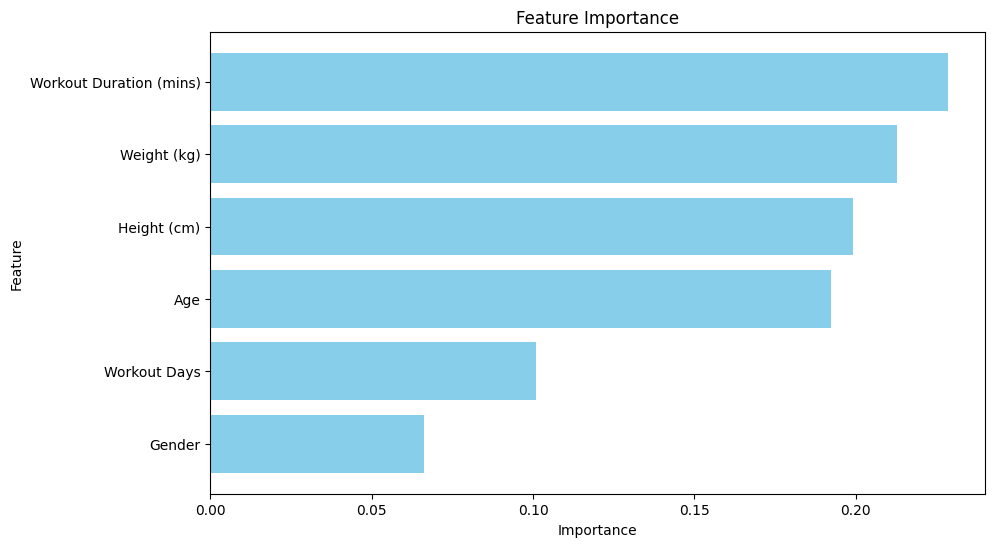

                   Feature  Importance
4  Workout Duration (mins)    0.228658
3              Weight (kg)    0.212593
2              Height (cm)    0.199117
0                      Age    0.192448
5             Workout Days    0.100896
1                   Gender    0.066288


In [ ]:
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_


feature_importance_df = pd.DataFrame({
  'Feature': X.columns,
  'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

In [15]:
import pandas as pd
import numpy as np
import joblib
import requests
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [17]:
# Define columns to use
columns_needed = [
    'Age',
    'Gender',
    'Height (m)',
    'Weight (kg)',
    'Session_Duration (hours)',
    'Workout_Type'
]

# Check for missing columns
missing_cols = [col for col in columns_needed if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

# Subset and copy data
df_selected = df[columns_needed].copy()

# Add synthetic Workout Days column
np.random.seed(42)
df_selected["Workout Days"] = np.random.choice([2, 3, 4, 5, 6], size=len(df_selected))

# Encode categorical columns
label_encoders = {}
for col in ['Gender', 'Workout_Type']:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    label_encoders[col] = le

# Split features and target
X = df_selected.drop(columns=['Workout_Type'])
y = df_selected['Workout_Type']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training/testing to avoid overfitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'criterion': ['gini']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Best model
rf_model = grid_search.best_estimator_

# Evaluation on test set
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("✅ Accuracy:", accuracy)
print("✅ F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save model and tools
joblib.dump(rf_model, "custom_rf_workout_model.pkl")
joblib.dump(scaler, "custom_rf_scaler.pkl")
joblib.dump(label_encoders, "custom_rf_label_encoders.pkl")

# Recommendation function
def recommend_workout(user_input):
    feature_order = ['Age', 'Gender', 'Height (m)', 'Weight (kg)', 'Session_Duration (hours)', 'Workout Days']
    input_vector = []
    for feature in feature_order:
        val = user_input[feature]
        if feature in label_encoders:
            val = label_encoders[feature].transform([val])[0]
        input_vector.append(val)
    input_df = pd.DataFrame([input_vector], columns=feature_order)
    input_scaled = scaler.transform(input_df)
    pred_code = rf_model.predict(input_scaled)[0]
    workout_type = label_encoders['Workout_Type'].inverse_transform([pred_code])[0]
    return workout_type

# ✅ Example usage
example_user = {
    'Age': 22,
    'Gender': 'Male',
    'Height (m)': 1.63,
    'Weight (kg)': 60,
    'Session_Duration (hours)': 0.75,  # 45 mins
    'Workout Days': 5
}

recommended_workout = recommend_workout(example_user)
print("💪 Recommended Workout Type:", recommended_workout)

✅ Accuracy: 0.2358974358974359
✅ F1 Score: 0.23571749254386345

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.33      0.28        46
           1       0.27      0.26      0.27        42
           2       0.21      0.26      0.23        47
           3       0.22      0.13      0.17        60

    accuracy                           0.24       195
   macro avg       0.24      0.24      0.24       195
weighted avg       0.23      0.24      0.23       195

💪 Recommended Workout Type: HIIT


In [18]:
# Define columns to use
columns_needed = [
    'Age',
    'Gender',
    'Height (m)',
    'Weight (kg)',
    'Session_Duration (hours)',
    'Workout_Type'
]

# Check for missing columns
missing_cols = [col for col in columns_needed if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

# Subset and copy data
df_selected = df[columns_needed].copy()

# Add synthetic Workout Days column
np.random.seed(42)
df_selected["Workout Days"] = np.random.choice([2, 3, 4, 5, 6], size=len(df_selected))

# Encode categorical columns
label_encoders = {}
for col in ['Gender', 'Workout_Type']:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    label_encoders[col] = le

# Split features and target
X = df_selected.drop(columns=['Workout_Type'])
y = df_selected['Workout_Type']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model hyperparameter tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'criterion': ['gini']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1_macro'
)
grid_search.fit(X_train, y_train)

# Best model
rf_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("✅ Accuracy:", accuracy)
print("✅ F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save model, scaler, encoders
joblib.dump(rf_model, "custom_rf_workout_model.pkl")
joblib.dump(scaler, "custom_rf_scaler.pkl")
joblib.dump(label_encoders, "custom_rf_label_encoders.pkl")

# ===============================
# 🧠 Recommendation Function
# ===============================
def recommend_workout(user_input):
    feature_order = ['Age', 'Gender', 'Height (m)', 'Weight (kg)', 'Session_Duration (hours)', 'Workout Days']
    
    # Load tools
    model = joblib.load("custom_rf_workout_model.pkl")
    scaler = joblib.load("custom_rf_scaler.pkl")
    encoders = joblib.load("custom_rf_label_encoders.pkl")
    
    input_vector = []
    for feature in feature_order:
        val = user_input[feature]
        if feature in encoders:
            val = encoders[feature].transform([val])[0]
        input_vector.append(val)
    
    input_df = pd.DataFrame([input_vector], columns=feature_order)
    input_scaled = scaler.transform(input_df)
    
    pred_code = model.predict(input_scaled)[0]
    workout_type = encoders['Workout_Type'].inverse_transform([pred_code])[0]
    return workout_type

# ===============================
# 🧪 Example Usage
# ===============================
example_user = {
    'Age': 25,
    'Gender': 'Male',
    'Height (m)': 1.75,
    'Weight (kg)': 70,
    'Session_Duration (hours)': 1,
    'Workout Days': 5
}

predicted = recommend_workout(example_user)
print("🏋️ Recommended Workout Type:", predicted)


✅ Accuracy: 0.2358974358974359
✅ F1 Score: 0.23571749254386345

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.33      0.28        46
           1       0.27      0.26      0.27        42
           2       0.21      0.26      0.23        47
           3       0.22      0.13      0.17        60

    accuracy                           0.24       195
   macro avg       0.24      0.24      0.24       195
weighted avg       0.23      0.24      0.23       195

🏋️ Recommended Workout Type: HIIT


Catboost

In [21]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# -----------------------------------------------
# 1. Define columns
columns_needed = [
    'Age', 'Gender', 'Height (m)', 'Weight (kg)',
    'Session_Duration (hours)', 'Workout_Type'
]

# 2. Check for missing columns
missing_cols = [col for col in columns_needed if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

# 3. Select and copy data
df_selected = df[columns_needed].copy()

# 4. Add synthetic feature
np.random.seed(42)
df_selected["Workout Days"] = np.random.choice([2, 3, 4, 5, 6], size=len(df_selected))

# 5. Separate target and features
y = df_selected['Workout_Type']
X = df_selected.drop(columns=['Workout_Type'])

# 6. Identify categorical columns for CatBoost
cat_features = ['Gender']  # use column names (not indexes)

# 7. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------------
# 8. Build and train CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=50
)

cat_model.fit(X_train, y_train, cat_features=cat_features)

# -----------------------------------------------
# 9. Predict & evaluate
y_pred = cat_model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# (Optional) Save model
cat_model.save_model("catboost_workout_model.cbm")

0:	learn: 0.3688946	total: 159ms	remaining: 47.7s
50:	learn: 0.6195373	total: 427ms	remaining: 2.09s
100:	learn: 0.7442159	total: 687ms	remaining: 1.35s
150:	learn: 0.8380463	total: 970ms	remaining: 957ms
200:	learn: 0.8958869	total: 1.25s	remaining: 615ms
250:	learn: 0.9293059	total: 1.53s	remaining: 299ms
299:	learn: 0.9562982	total: 1.85s	remaining: 0us
✅ Accuracy: 0.26153846153846155

Classification Report:
               precision    recall  f1-score   support

      Cardio       0.22      0.33      0.27        46
        HIIT       0.26      0.26      0.26        42
    Strength       0.28      0.32      0.30        47
        Yoga       0.31      0.17      0.22        60

    accuracy                           0.26       195
   macro avg       0.27      0.27      0.26       195
weighted avg       0.27      0.26      0.26       195



In [22]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Add BMI
df_selected["BMI"] = df_selected["Weight (kg)"] / (df_selected["Height (m)"] ** 2)

# Features and target
y = df_selected['Workout_Type']
X = df_selected.drop(columns=['Workout_Type'])

# Cat features (include Workout Days if you think it's categorical)
cat_features = ['Gender']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CatBoost model
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced',
    eval_metric='Accuracy',
    random_seed=42
)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    verbose=50
)

# Evaluate
y_pred = cat_model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

0:	learn: 0.3701471	test: 0.2576333	best: 0.2576333 (0)	total: 6.9ms	remaining: 6.89s
50:	learn: 0.5819217	test: 0.2544313	best: 0.2764057 (1)	total: 399ms	remaining: 7.42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2764056812
bestIteration = 1

Shrink model to first 2 iterations.
✅ Accuracy: 0.2717948717948718

Classification Report:
               precision    recall  f1-score   support

      Cardio       0.32      0.18      0.23        51
        HIIT       0.27      0.45      0.34        44
    Strength       0.28      0.29      0.29        52
        Yoga       0.23      0.19      0.20        48

    accuracy                           0.27       195
   macro avg       0.27      0.28      0.26       195
weighted avg       0.28      0.27      0.26       195



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Add BMI
df_selected["BMI"] = df_selected["Weight (kg)"] / (df_selected["Height (m)"] ** 2)

# Features and target
y = df_selected['Workout_Type']
X = df_selected.drop(columns=['Workout_Type'])

# Encode categorical features (e.g., Gender)
label_encoder = LabelEncoder()
X['Gender'] = label_encoder.fit_transform(X['Gender'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression model
logreg_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'  # You can add class_weight='balanced' if the data is imbalanced
)

logreg_model.fit(X_train, y_train)

# Evaluate
y_pred = logreg_model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.22564102564102564

Classification Report:
               precision    recall  f1-score   support

      Cardio       0.28      0.29      0.29        51
        HIIT       0.18      0.20      0.19        44
    Strength       0.32      0.17      0.23        52
        Yoga       0.17      0.23      0.19        48

    accuracy                           0.23       195
   macro avg       0.24      0.23      0.23       195
weighted avg       0.24      0.23      0.23       195



c:\Users\AHC\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


: 

In [ ]:
# Select relevant columns
columns_needed = ['Age', 'Gender', 'Height (m)', 'Weight (kg)', 'Session_Duration (hours)', 'Workout_Type','Workout_Frequency (days/week)']
df_selected = df[columns_needed].copy()


# Add synthetic feature
np.random.seed(42)
df_selected["Workout Days"] = np.random.choice([2, 3, 4, 5, 6], size=len(df_selected))

# Encode categorical variables
label_encoders = {}
for col in ['Gender', 'Workout_Type']:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col])
    label_encoders[col] = le

# Split features and target
X = df_selected.drop(columns=['Workout_Type'])
y = df_selected['Workout_Type']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build Autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(1e-5))(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16, shuffle=True, verbose=0)

# Use encoder to transform data
encoder = Model(inputs=input_layer, outputs=encoded)
X_encoded = encoder.predict(X_scaled)

# Train KNN on encoded features
knn_model = KNeighborsClassifier()
knn_model.fit(X_encoded, y)

# Evaluate the model
y_pred = knn_model.predict(X_encoded)
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='macro')

print("✅ Accuracy:", accuracy)
print("✅ F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y, y_pred))

# Save models and encoders
joblib.dump(knn_model, "custom_knn_workout_model.pkl")
joblib.dump(scaler, "custom_scaler.pkl")
joblib.dump(label_encoders, "custom_label_encoders.pkl")
encoder.save("custom_encoder_model.h5")


# Function to recommend workout type
def recommend_workout(user_input):
    feature_order = ['Age', 'Gender', 'Height (m)', 'Weight (kg)', 'Session_Duration (hours)', 'Workout_Type','Workout_Frequency (days/week)']
    input_vector = []
    for feature in feature_order:
        val = user_input[feature]
        if feature in label_encoders:
            val = label_encoders[feature].transform([val])[0]
        input_vector.append(val)

    # 👇 Here is input_df (single-row DataFrame of user input)
    input_df = pd.DataFrame([input_vector], columns=feature_order)
    
    # Standardize and encode
    input_scaled = scaler.transform(input_df)
    input_encoded = encoder.predict(input_scaled)

    # Predict workout type
    pred_code = knn_model.predict(input_encoded)[0]
    workout_type = label_encoders['Workout_Type'].inverse_transform([pred_code])[0]
    return workout_type


# API Helpers
def get_exercises_by_target(muscle, limit=3):
    url = f"https://exercisedb.p.rapidapi.com/exercises/target/{muscle.lower()}"
    headers = {
        'x-rapidapi-key': "e90a745955mshaef134b6f28017ep1ed56bjsn7fd09b596b4c",
        'x-rapidapi-host': "exercisedb.p.rapidapi.com"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()[:limit]
    else:
        return []

def get_full_body_exercises():
    targets = ['pectorals', 'lats', 'quads', 'glutes', 'abs', 'delts', 'triceps']
    all_exercises = []
    for muscle in targets:
        exs = get_exercises_by_target(muscle, limit=1)
        if exs:
            all_exercises.append(exs[0])
    return all_exercises

# Map workout type to target muscle
workout_target_map = {
    "cardio": "quads",
    "strength": "quads",
    "hiit": "abs",
    "yoga": "glutes",
    "cycling": "hamstrings",
    "running": "calves",
    "full body": "all"
}

# Generate a personalized workout plan
def generate_workout_plan(user_input):
    workout_type = recommend_workout(user_input)
    print(f"✅ Recommended Workout Type: {workout_type}")
    target = workout_target_map.get(workout_type.lower(), "abs")
    if target == "all":
        exercises = get_full_body_exercises()
        print("\n🔥 Full Body Workout:")
    else:
        exercises = get_exercises_by_target(target, limit=5)
        print(f"\n🔥 {workout_type.title()} Workout:")

    for i, ex in enumerate(exercises, 1):
        print(f"\nDay {i}: {ex['name'].title()} ({ex['target']})")
        print(f"🔹 Body Part: {ex['bodyPart']}")
        print(f"🔹 Equipment: {ex['equipment']}")
        print(f"🖼 Image: {ex['gifUrl']}")


example_user = {
    'Age': 20,
    'Gender': 'Female',
    'Height (m)': 163,
    'Weight (kg)': 60,
    'Session_Duration (hours)': 0.45,
    'Workout_Frequency (days/week)': 3
}

generate_workout_plan(example_user)